In [7]:
import tensorflow
from tensorflow import keras
import cv2
import os
import pandas as pd
import numpy as np 
import re
import itertools
import random
import warnings
import matplotlib.pyplot as plt

# Importation de données et preprocessing

In [12]:
# to_np_array c'est une fonction auxilaiire qui transorme une image à un np array
def to_np_array(list1):
    img_data = []
    img_labels = []
    for i in range(len(list1)):
        img_data.append(list1[i][1])
        img_labels.append(list1[i][2])
    img_data = np.array(img_data)
    img_labels = np.array(img_labels)
    return img_data, img_labels

def Data_Maker():
    #emplacmendes des images
    direc = "C:/Users/Administrator/Desktop/asl_alphabet_train/asl_alphabet_train"
    # classe de l'image par son répertoire
    classes=[file for file in  os.listdir(direc)]
    all_files=[]
    # boucle for pour lire les images avec cv2, sachant que il y a un resize de (100,100), taille initiale (200,200)
    for c in classes:
         all_files.append([[f, cv2.resize(cv2.imread(direc+'/'+c+'/'+f), (100,100)) ,classes.index(c)] for f in os.listdir(direc+'/'+c)])
    classed_data_flat = []
    for a in all_files:
        for b in a :
            classed_data_flat.append(b)
    random.shuffle(classed_data_flat)
    return to_np_array(classed_data_flat)

In [13]:
images,classes = Data_Maker()

In [14]:
# la totalité de notre base
print(len(images),len(classes))

87000 87000


# Deep learning model

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [21]:
# Partitionner les données dans en train, validation et test
X_train, Y_train  = images,classes
# 90%-10% de données: train - test
train_data, X_test, train_labels,Y_test = model_selection.train_test_split(X_train, Y_train, test_size=0.10)
# 90%-10% de train: train - validation
train_data, val_data, train_labels, val_labels = model_selection.train_test_split(train_data, train_labels, test_size=0.10)

In [22]:
# les tailles des notre partition
print(len(train_data), " ", len(train_labels), " ", len(val_data), " ", len(val_labels), " ", len(X_test), " ", len(Y_test))


70470   70470   7830   7830   8700   8700


In [23]:
# on peut bien observer que c'est une image RGB de dimensions 100X1OO
train_data.shape[1:]

(100, 100, 3)

In [24]:
# créatyion du model DL avec Keras
def build_model(classes):
    model = keras.Sequential([
        #Input layer qui prend les dimensions d'une image
        layers.InputLayer(input_shape=train_data.shape[1:]),
        #Serie de 3 couche convolutives et max pooling pour feature extraction
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # couche flatten pour transformer les données matricielles en images
        layers.Flatten(),
        # couche dense pour classification
        layers.Dense(1024, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(classes, activation="softmax")
    ])
    return model
    

In [25]:
model = build_model(len(set(train_labels)))
#Architecture du modele
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [26]:
# Compilation du  model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# Early stopping pour eviter l'overfiiting
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, min_delta = 0.01, mode = "min" )
# Training model
history = model.fit(train_data, train_labels, epochs=100, validation_data=(val_data, val_labels)  , callbacks=[callback], batch_size=64)


Epoch 1/100
1102/1102 [==============================] - 72s 61ms/step - loss: 1.2833 - accuracy: 0.7261 - val_loss: 0.1742 - val_accuracy: 0.9384
Epoch 2/100
1102/1102 [==============================] - 67s 61ms/step - loss: 0.1567 - accuracy: 0.9485 - val_loss: 0.0779 - val_accuracy: 0.9769
Epoch 3/100
1102/1102 [==============================] - 67s 61ms/step - loss: 0.1164 - accuracy: 0.9627 - val_loss: 0.0775 - val_accuracy: 0.9793


In [27]:
def accuracy_plot(history):
    plt.figure(figsize=(7, 4))    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.ylim(ymin=0 , ymax=1)
    plt.show()
    
    plt.figure(figsize=(7, 4))    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

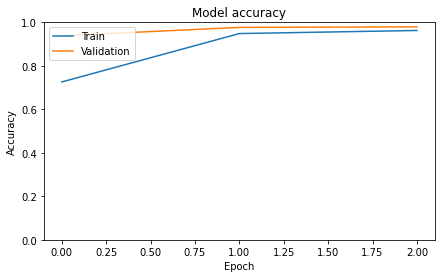

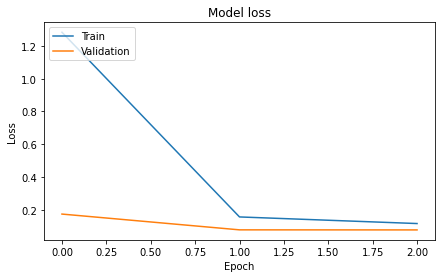

In [28]:
# Observations de l'evolutions de l'accuracy et le loss function durant la phase d'entrainement
accuracy_plot(history)

In [29]:
my_classes=[file for file in  os.listdir("C:/Users/Administrator/Desktop/asl_alphabet_train/asl_alphabet_train")]
my_classes
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.rcParams["figure.figsize"] = (20,3)

In [30]:
# Prédiction des données Test
pred = model.predict(X_test)
pred_y = pred.argmax(axis=-1)
# création de la matrice de confution
cm = confusion_matrix(Y_test,pred_y)

Confusion matrix, without normalization


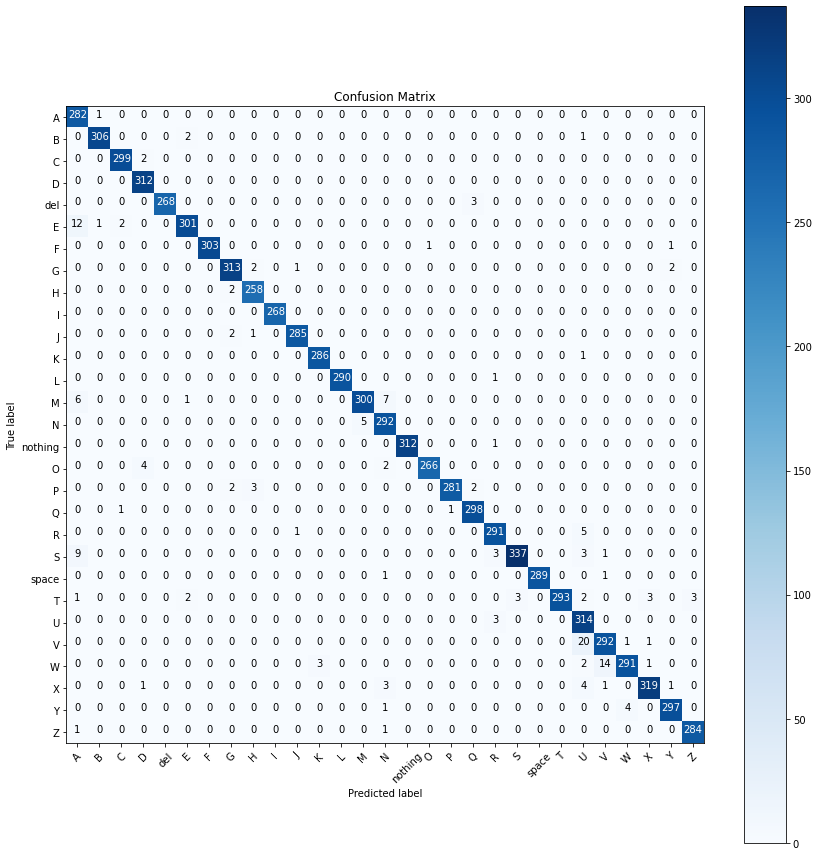

In [31]:
plot_confusion_matrix(cm=cm, classes=my_classes, title='Confusion Matrix')

In [32]:
def imshow_(img):
    import warnings
    with warnings.catch_warnings():
        import matplotlib.image as mpimg
        img = mpimg.imread("C:/Users/Administrator/Desktop/Alzheimer_s Dataset/test/"+name+".jpg")
        img = cv2.resize(200,200)
        imgplot = plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(str(proba*100)+'% is '+ stade)
    return imgplot

In [61]:
def predictor(name,classes,model):
    direct = "C:/Users/Administrator/Desktop/test_2/"
    img = cv2.imread(direct+name+".jpg")
    img = cv2.resize(img, (100,100))
    img=np.array(img)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    values= []
    for x in pred:
        for b in x:
            values.append(b)
    proba = round(float(max(values)),4)*100
    my_label = str(my_classes[values.index(max(values))])
    return str("Your Prediction is--- "+my_classes[values.index(max(values))]+" ---with probablity: "+str(proba)+"%  while the actual label is: "+my_label),im_show(name)


def im_show(name):
    import warnings
    plt.figure(figsize=(10, 10))
    with warnings.catch_warnings():
        import matplotlib.image as mpimg
        img = mpimg.imread("C:/Users/Administrator/Desktop/test_2/"+name+".jpg")
        imgplot = plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title("The letter is: "+name)
    return imgplot

In [62]:
def test_names():
    c =  [a for a in os.listdir("C:/Users/Administrator/Desktop/test_2")]
    return [b[0]  for b in c]
test_2= test_names()
test_2

['B', 'I', 'L', 'P', 'Q', 'R', 'W', 'X']

('Your Prediction is--- W ---with probablity: 100.0%  while the actual label is: W',
 <matplotlib.image.AxesImage at 0x1c242c50400>)

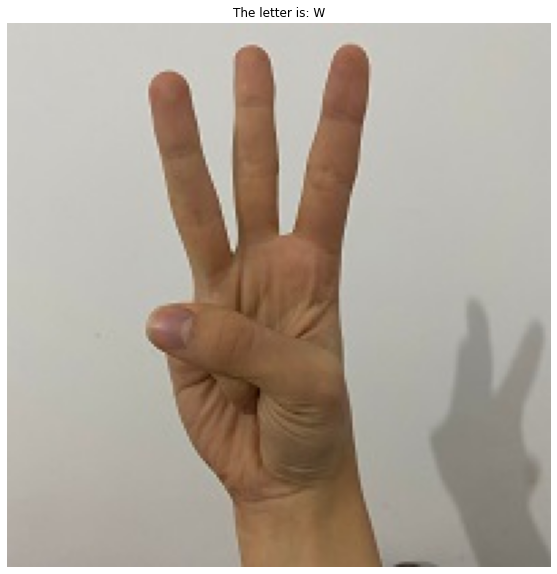

In [67]:
predictor("W",my_classes,model)

('Your Prediction is--- Q ---with probablity: 97.16%  while the actual label is: Q',
 <matplotlib.image.AxesImage at 0x1c215eba790>)

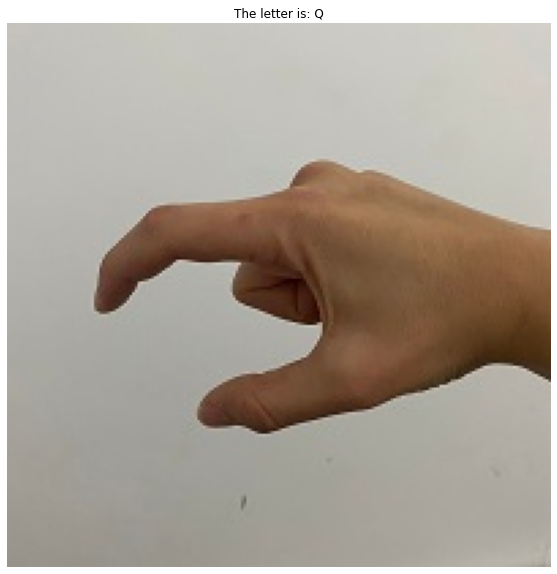

In [68]:
predictor("Q",my_classes,model)

('Your Prediction is--- P ---with probablity: 100.0%  while the actual label is: P',
 <matplotlib.image.AxesImage at 0x1c21de49af0>)

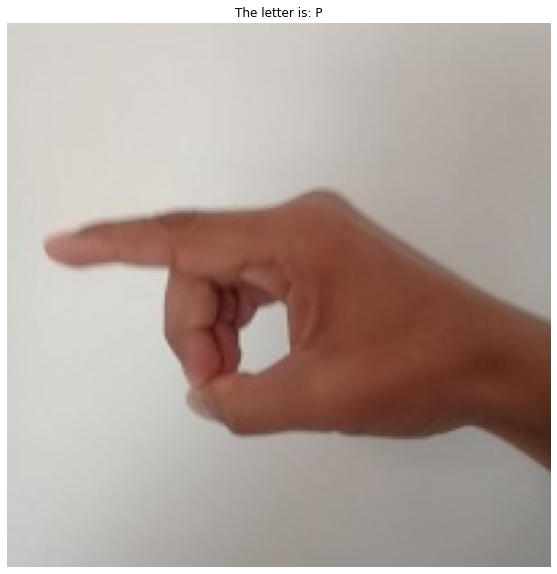

In [69]:
predictor("P",my_classes,model)

('Your Prediction is--- I ---with probablity: 67.63%  while the actual label is: I',
 <matplotlib.image.AxesImage at 0x1c226dcfe50>)

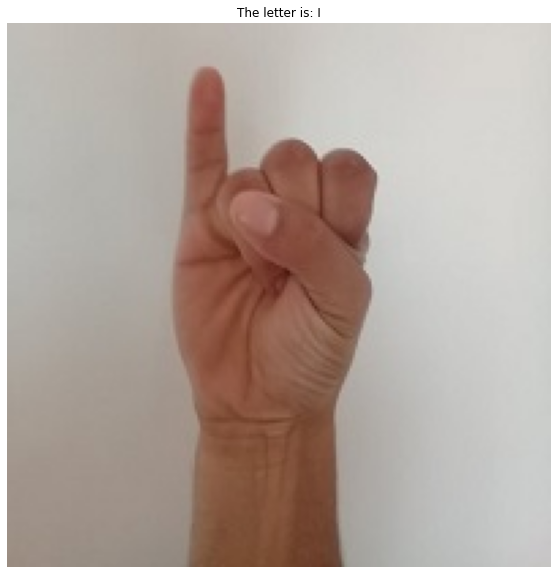

In [70]:
predictor("I",my_classes,model)

# pre Trained model:  InceptionV3

In [73]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
model_3 = keras.Sequential()
model.add(InceptionV3(weights="imagenet",input_shape=(100,100,3),include_top=False))
model_3.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model_3.add(layers.Dropout(0.3))
model_3.add(layers.Dense(len(classes_2),activation="softmax"))

model_3.summary()

In [ ]:
# Compiling model
opt = keras.optimizers.Adam(learning_rate=0.001)
pretrained_model3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# Early stopping 
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, min_delta = 0.01, mode = "min" )
# Training model
#history = model.fit(train_data, train_labels, epochs=100, validation_data=(val_data, val_labels)  , callbacks=[callback], batch_size=64)
history2 = pretrained_model3.fit(train_data, train_labels, epochs=100, validation_data=(val_data, val_labels)  , batch_size=128)


In [ ]:
accuracy_plot(history2)

In [ ]:
pred2 = model.predict(X_test)
pred_y2 = pred.argmax(axis=-1)

cm2 = confusion_matrix(Y_test,pred_y2)

In [ ]:
plot_confusion_matrix(cm=cm2, classes=classes_2, title='Confusion Matrix')


In [ ]:
predictor("W",classes_2,model)
im_show("W")
